# Fake News Detection by Stance Prediction

The task is to detect fake news by **predicting the stance** associated to every news article in the __[FNC Dataset](https://github.com/FakeNewsChallenge/fnc-1)__.


## Data Input & Preprocessing

Read csv files into Pandas DataFrames and merge them on `Body ID`


In [1]:
import pandas as pd

merged = [None] * 2
for idx, prefix in enumerate(['train', 'test']):
    body_df = pd.read_csv(f'{prefix}_bodies.csv', index_col=0)
    stance_df = pd.read_csv(f'{prefix}_stances.csv')

    merged_df = pd.merge(stance_df, body_df, on='Body ID')
    merged_df = merged_df.rename(
        columns={'Headline': 'headline', 'Body ID': 'body_id',
                     'Stance': 'stance', 'articleBody': 'body'}
    )
    merged[idx] = merged_df

train_df, test_df = merged

In [2]:
import random

len_train = len(train_df)
sample_indices = random.sample(range(len_train), k=int(0.2*len_train))

val_df = train_df.iloc[sample_indices]
train_df = train_df.drop(sample_indices)

### Data Exploration

The training dataset consists of 39978 headline and article pairs.
The validation dataset consists of 9994 headline and article pairs.
The test dataset consists of 25413 headline and article pairs.


                                                headline  body_id     stance
2790   Do all dogs go to heaven? Pope tells grieving ...     1905      agree
14827  Priest who died for 48 minutes says he met God...     1605  unrelated
36593  Did a plumber's pick-up truck from Texas end u...     2379    discuss
16614  White House Fence Jumper Made It Further Into ...      311  unrelated
42664             Rumors of ISIS leader's death debunked      789  unrelated
34545  Devoted pet owner spends £300 to save his GOLD...     1539  unrelated
10101  Christian Bale Pulls Out of Upcoming Steve Job...      296  unrelated
19985  Apple 12-Inch MacBook Air Details Emerge; Devi...     1423  unrelated
44413  Canadian-Israeli woman reportedly kidnapped by...     2445  unrelated
33390  Parents are furious aft

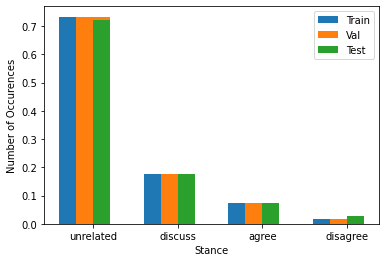

In [3]:
import matplotlib.pyplot as plt

dfs = [train_df, val_df, test_df]
labels = ['training', 'validation', 'test']
df_zip = zip(dfs, labels)
for df, label in df_zip:
    print(f'The {label} dataset consists of {len(df)} headline and article pairs.')

print('\n')

# dropping body text to not clog up output. N.B. drop is not inplace by default
print(train_df.drop(columns=['body']).sample(10))   
print('\n')

train_counts = train_df['stance'].value_counts(normalize=True)
test_counts = test_df['stance'].value_counts(normalize=True)

val_counts = val_df['stance'].value_counts(normalize=True)

plt.figure()
plt.bar(train_counts.index,train_counts.values, width=-0.4, align='edge', label='Train')
plt.bar(val_counts.index,train_counts.values, width=0.4, align='center', label='Val')
plt.bar(test_counts.index,test_counts.values, width=0.2, align='edge', label='Test')
plt.legend()
plt.xlabel('Stance')
plt.ylabel('Number of Occurences')

plt.show()


## Feature Extraction

### TF/IDF

Uses the `scikit-learn` module's implementation of TF/IDF. Built on both the headlines and bodies in the train dataset, and fit to both the train and test dataset.


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer(decode_error='ignore', lowercase=True, min_df=2)

raw = {label: (df['headline'] + '\n' +  df['body']).values
                              for df, label in zip(dfs, labels)}


tf_idf = {'training': vectorizer.fit_transform(raw['training'].astype('U'))}
for key, value in raw.items():
    if key != 'training':
        tf_idf[key] = vectorizer.transform(value.astype('U'))

for key, value in tf_idf.items():
    print(f'{key} feature size: {value.shape}')

training feature size: (39978, 22680)
validation feature size: (9994, 22680)
test feature size: (25413, 22680)


#### Sampling ten random features from the TF/IDF dictionary

In [5]:
print(random.sample(vectorizer.get_feature_names(), 10))

['freeing', 'resolved', 'carjacked', 'exchange', 'piper', 'regardt', 'hamish', 'publicly', 'comparison', 'slow']


### BERT Transformer

In [6]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
LEN_MAX_INPUT = tokenizer.max_model_input_sizes['bert-base-uncased']

In [7]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:LEN_MAX_INPUT-2]
    return tokens

#### Create a dataset

Get item returns BERT tokenized IDs and their stance

In [8]:
import torch
from torch.utils import data

class DataFrameDataset(data.Dataset):

    def __init__(self, df, stance_mapping):
        self.df = df
        self.map = stance_mapping


    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        items = self.df.iloc[idx]
        headline = self._get_token_ids(items['headline'])
        body = self._get_token_ids(items['body'])
        stance = torch.tensor(self.map[items['stance']])
        return torch.stack([headline, body]), stance

    def _get_token_ids(self, text):
        with torch.no_grad():
            tokens = tokenize_and_cut(text)
            ids = tokenizer.convert_tokens_to_ids(tokens)
            ids = [tokenizer.cls_token_id] + ids + [tokenizer.sep_token_id]
            ids.extend([0 for _ in range(512 - len(ids))])
            return torch.tensor(ids)
        
stance_mapping = {
    'unrelated': 0,
    'discuss': 1,
    'agree': 2,
    'disagree': 3
}
datasets = [DataFrameDataset(df, stance_mapping) for df in dfs]

## Related / Unrelated Classification

### Simple ML Method

#### Logistic Regression

Statsmodels Logistic Regression, trained on the whole training dataset

In [25]:
train_TFIDF, test_TFIDF = tf_idf['training'], tf_idf['test']

# TODO - messy, needs cleaning
train_BERT, _, test_BERT = [next(iter(data.DataLoader(d, batch_size=len(d))))[0]
                                                for d in datasets]

train_Y = train_df['stance'] != 'unrelated'
test_Y = test_df['stance'] != 'unrelated'

In [26]:
from sklearn.linear_model import LogisticRegression

tf_idf_model = LogisticRegression(max_iter=2000)
tf_idf_model.fit(train_TFIDF, train_Y)

print(tf_idf_model.score(train_TFIDF, train_Y))
print(tf_idf_model.score(test_TFIDF, test_Y))

bert_model = LogisticRegression(max_iter=2000)
bert_model.fit(train_BERT, train_Y)

print(bert_model.score(train_BERT, train_Y))
print(bert_model.score(test_BERT, test_Y))


0.8395617589674321
0.5820249478613309
0.7326279453699535
0.7214024318262307


### Deep Learning Method


In [11]:
train_loader, _, test_loader = [data.DataLoader(d, batch_size=32)
                                                for d in datasets]

In [12]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

train_iter, val_iter, test_iter = [iter(cycle(x)) for x in dataloaders]

NameError: name 'dataloaders' is not defined